In [1]:
# Importing necessary libraries

!pip install cellpylib

import cellpylib as cpl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch import Tensor
import seaborn as sns
import time
import math
import matplotlib.cm as cm # For colourmap plots later
from tqdm import tqdm

In [14]:
# Optional. Makes the outputs more readable by surpressing certain warnings.

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [24]:
# Parameters

# Data generation parameters
data_size = 100 # the number of data points in each row of data
timesteps = 100 # the number of timesteps which each programme is run for before the output is used to train the model

# Model parameters
num_epochs = 1000  # Number of training epochs #Later move to 1000 epochs
hidden_size = 512  # Update with the desired size of the hidden layer
learning_rate = 0.005 # learning rate used later in the optimizer
batch_size = 128 # Batch size used when creating the train and test datasets. 32 is more suitable for this problem. 
epochs = np.arange(0,num_epochs, 1) # Used in plotting
accuracy_frequency = 10 # Used in the evaluation of the model #Later move to 1. moving_avg will clear up plots

In [25]:
def prog_dist_weight_hierarchicalclustering():
    
    hierarchical_clustering_order = [96, 0, 160, 32, 224, 192, 8, 136, 40, 168, 64, 128, 164, 36, 104, 6, 20, 18, 146, 5, 17, 196, 3, 48, 10, 
                                     12, 34, 68, 80, 140, 134, 148, 38, 52, 33, 108, 74, 88, 172, 228, 4, 72, 1, 2, 16, 44, 100, 144, 130, 132, 
                                     194, 66, 24, 152, 41, 97, 7, 21, 37, 26, 82, 98, 56, 200, 116, 138, 208, 163, 76, 42, 46, 112, 177, 22, 
                                     131, 145, 35, 49, 162, 176, 19, 133, 9, 65, 11, 81, 25, 67, 141, 13, 69, 197, 137, 193, 147, 143, 157, 109, 
                                     199, 213, 126, 57, 226, 129, 161, 23, 232, 184, 122, 142, 83, 27, 39, 71, 102, 99, 86, 204, 153, 180, 210, 
                                     105, 212, 15, 53, 50, 60, 85, 89, 225, 29, 149, 169, 45, 156, 106, 165, 150, 51, 120, 135, 154, 30, 75, 198,
                                     178, 179, 43, 90, 101, 170, 166, 77, 113, 195, 240, 54, 70, 73, 28, 14, 84, 87, 31, 107, 121, 181, 91, 167, 
                                     236, 185, 227, 209, 244, 139, 241, 58, 174, 205, 114, 171, 151, 62, 118, 59, 115, 186, 242, 55, 111, 94, 
                                     125, 47, 61, 103, 117, 110, 124, 93, 92, 78, 79, 248, 250, 252, 234, 254, 251, 239, 235, 255, 249, 238, 
                                     253, 218, 219, 233, 159, 215, 182, 183, 95, 119, 207, 63, 220, 206, 175, 221, 243, 187, 245, 158, 214, 155, 
                                     211, 123, 201, 173, 229, 237, 127, 216, 223, 247, 191, 202, 217, 222, 190, 203, 246, 230, 189, 188, 231]
    #programmes = [0, 10, 20, 63, 64, 95, 96, 110, 125, 195, 204, 225, 249, 255] #rel_list
    programmes = [0, 10, 20, 63, 64, 95, 96, 110, 125, 195, 204, 225]
    prog_list = np.zeros(256)
    for prog in programmes:
        zipf_weight = (hierarchical_clustering_order[prog] + 10)**(-1)
        prog_list[prog] = zipf_weight
    prog_list_norm = [x / sum(prog_list) for x in prog_list]
    return prog_list_norm

def prog_dist_antiweight_hierarchicalclustering(): #UNCORRECTED FUNCTION
    
    hierarchical_clustering_order = [96, 0, 160, 32, 224, 192, 8, 136, 40, 168, 64, 128, 164, 36, 104, 6, 20, 18, 146, 5, 17, 196, 3, 48, 10, 
                                     12, 34, 68, 80, 140, 134, 148, 38, 52, 33, 108, 74, 88, 172, 228, 4, 72, 1, 2, 16, 44, 100, 144, 130, 132, 
                                     194, 66, 24, 152, 41, 97, 7, 21, 37, 26, 82, 98, 56, 200, 116, 138, 208, 163, 76, 42, 46, 112, 177, 22, 
                                     131, 145, 35, 49, 162, 176, 19, 133, 9, 65, 11, 81, 25, 67, 141, 13, 69, 197, 137, 193, 147, 143, 157, 109, 
                                     199, 213, 126, 57, 226, 129, 161, 23, 232, 184, 122, 142, 83, 27, 39, 71, 102, 99, 86, 204, 153, 180, 210, 
                                     105, 212, 15, 53, 50, 60, 85, 89, 225, 29, 149, 169, 45, 156, 106, 165, 150, 51, 120, 135, 154, 30, 75, 198,
                                     178, 179, 43, 90, 101, 170, 166, 77, 113, 195, 240, 54, 70, 73, 28, 14, 84, 87, 31, 107, 121, 181, 91, 167, 
                                     236, 185, 227, 209, 244, 139, 241, 58, 174, 205, 114, 171, 151, 62, 118, 59, 115, 186, 242, 55, 111, 94, 
                                     125, 47, 61, 103, 117, 110, 124, 93, 92, 78, 79, 248, 250, 252, 234, 254, 251, 239, 235, 255, 249, 238, 
                                     253, 218, 219, 233, 159, 215, 182, 183, 95, 119, 207, 63, 220, 206, 175, 221, 243, 187, 245, 158, 214, 155, 
                                     211, 123, 201, 173, 229, 237, 127, 216, 223, 247, 191, 202, 217, 222, 190, 203, 246, 230, 189, 188, 231]
    
    programmes_prob_distribution = []
    for i in range(256):
        zipf_weight = (hierarchical_clustering_order.index(255 - i) + 10)**(-1)
        programmes_prob_distribution.append(zipf_weight)
    return programmes_prob_distribution

In [26]:
programmes_prob_distribution = prog_dist_weight_hierarchicalclustering()

In [27]:
# Model Initialisation / Training setup

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.bn2 = nn.BatchNorm1d(num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.bn2(out)
        return out

# Define the input size, hidden size, and number of classes
input_size = data_size  # Update with the actual input size
num_classes = 256 #Number of potential classes, here stuck at 256

# Create an instance of the neural network
model = NeuralNetwork(input_size, hidden_size, num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [28]:
# Define a way to reset weights

def reset_weights(model):
    for module in model.modules():
        if isinstance(module, nn.Linear):
            module.reset_parameters()

In [29]:
# Data generation functions (where the programmes_considered have a probability distribution)

def create_data(data_size, programmes_prob_distribution, number_of_samples, timesteps):

    # Creating the dataset and labels variables to be populated later
    dataset = np.empty(shape=(number_of_samples, data_size), dtype=int) # each row is data_size length, with number_of_samples rows
    labels = np.empty(shape=(1, number_of_samples), dtype=int)

    # Stating the space of considered programmes
    programmes = np.arange(0,256,1)

    # Normalising the distribution in case it is not already normalised
    programmes_total = sum(programmes_prob_distribution)
    programmes_prob_distribution_norm = [x / programmes_total for x in programmes_prob_distribution]
    
    for i in range(number_of_samples):

        # Randomly selecting a rule number according to the probability distribution given
        rule_number = np.random.choice(a = programmes, size=None, replace=True, p = programmes_prob_distribution_norm)
        #print(f"Considering rule_number = ", rule_number)
        cellular_automaton = cpl.init_random(data_size)
        cellular_automaton = cpl.evolve(cellular_automaton, timesteps=timesteps, memoize=True, apply_rule=lambda n, c, t: cpl.nks_rule(n, rule_number))
        #print(cellular_automaton[-1])
        dataset[i] = cellular_automaton[-1]
        labels[:,i] = rule_number

    return [dataset, labels]

def data_loader(data_size, programmes_prob_distribution, number_of_samples, timesteps):

    # Generate the data according to input parameters
    [dataset, labels] = create_data(data_size, programmes_prob_distribution, number_of_samples, timesteps)
    labels = labels[0] # Deal with the fact that the output is a list of a single list

    # Shifting the labels such that they are indexed from 0. Required for cross entropy to work
    #labels = [x - min(labels) for x in labels] #!!! Not currently shifting labels in a test to alter them later - may help with training in smaller batches
    # Use data_split
    data = [(data_sample, label) for data_sample, label in zip(dataset, labels)]

    train_dataset, train_labels = zip(*data)
    
    tensor_train_dataset = TensorDataset(Tensor(train_dataset), Tensor(train_labels))
    
    train_loader = DataLoader(tensor_train_dataset, batch_size=batch_size, shuffle=True)

    return train_loader

In [30]:
# Evaluates a model over the space of all possible functions. Outputs a vector giving that performance

def model_evaluation(model, data_size, timesteps, batch_size):

    # State which programmes are being considered. In this case, it's all of them.
    #programmes_considered = np.arange(0,256,1) #NOTE: THIS DISABLING IS TEMPORARY. AIM TO REINTRODUCE IT
    programmes_considered = np.array([0, 10, 20, 63, 64, 95, 96, 110, 125, 195, 204, 225, 249, 255]) # The programmes used at the moment in autocorrelation

    accuracy_vector = np.empty(256)
    
    for programme in programmes_considered:

        programmes_prob_distribution = [0]*256
        programmes_prob_distribution[programme] = 1

        train_loader = data_loader(data_size, programmes_prob_distribution, batch_size, timesteps)

        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for data, labels in train_loader:
                outputs = model(data)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
            accuracy = 100 * correct / total #returns the accuracy as a percentage
            #print(f"For programme " + str(programme) + ": Accuracy = " + str(accuracy))
        accuracy_vector[programme] = accuracy
                
    return accuracy_vector

In [31]:
# Training loop (includes data generation). Note that here training and test loss cease to make much sense

def main_train(data_size, programmes_prob_distribution, batch_size, timesteps, num_epochs):

    # Initisalise training and test loss tracking variables
    training_loss = np.empty(num_epochs)

    # Initialise an array to track not only the general training and test loss, but also the accuracy on individual programme classification during training.
    # This is to attempt to see grokking.
    # Form: Each row of accuracy_array is an epoch, each column of accuracy_array is a binary 1 or 0 based on whether or not it was correctly classified. 
    #accuracy_frequency = 100 # Once every 100 epochs, the accuracy is measured
    accuracy_array = np.empty((math.floor(num_epochs/accuracy_frequency), 256))
    # Initialising variaable for tracking where in the accuracy_array to write data
    eval_count = 0
    # Each epoch here trains over 1 batch size of data (which at the moment is 32). Each epoch is therefore smaller and better controlled.
    for epoch in tqdm(range(num_epochs)):

        # Continually monitoring accuracy of the model by adjusting the accuracy_array
        if epoch%accuracy_frequency==0:
            accuracy_vector = model_evaluation(model, data_size, timesteps, batch_size)
            accuracy_array[eval_count] = accuracy_vector
            eval_count += 1
        
        train_loader = data_loader(data_size, programmes_prob_distribution, batch_size, timesteps)
        for data, labels in train_loader:
            # Forward pass
            outputs = model(data)
    
            #Shifting labels for loss calculation
            shifted_labels = labels - torch.min(labels)
            shifted_labels = shifted_labels.long()
            loss = criterion(outputs, shifted_labels)
                
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Print the loss after each epoch
        if epoch%100==0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")
        training_loss[epoch] = loss.item()

    return [training_loss, accuracy_array]

  0%|          | 1/1000 [00:30<8:24:57, 30.33s/it]

Epoch [1/1000], Loss: 5.602534770965576


 10%|█         | 101/1000 [09:13<2:48:26, 11.24s/it]

Epoch [101/1000], Loss: 4.155531406402588


 20%|██        | 201/1000 [18:36<2:25:09, 10.90s/it]

Epoch [201/1000], Loss: 3.19999623298645


 30%|███       | 301/1000 [26:52<2:05:45, 10.79s/it]

Epoch [301/1000], Loss: 2.9530560970306396


 40%|████      | 401/1000 [35:17<2:07:30, 12.77s/it]

Epoch [401/1000], Loss: 2.6089141368865967


 50%|█████     | 501/1000 [44:41<1:51:02, 13.35s/it]

Epoch [501/1000], Loss: 2.526925802230835


 60%|██████    | 601/1000 [53:32<1:17:10, 11.61s/it]

Epoch [601/1000], Loss: 2.333211660385132


 70%|███████   | 701/1000 [1:01:47<50:48, 10.20s/it]

Epoch [701/1000], Loss: 1.9389728307724


 80%|████████  | 801/1000 [1:11:53<52:34, 15.85s/it]  

Epoch [801/1000], Loss: 2.049804210662842


 90%|█████████ | 901/1000 [1:21:58<19:02, 11.54s/it]

Epoch [901/1000], Loss: 2.0471949577331543


100%|██████████| 1000/1000 [1:30:02<00:00,  5.40s/it]
C:\Users\plogo\AppData\Local\Temp\ipykernel_20828\1097752756.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow')  # You can choose different colormaps
  0%|          | 1/1000 [00:33<9:21:48, 33.74s/it]

Epoch [1/1000], Loss: 5.289035320281982


 10%|█         | 101/1000 [09:04<2:44:56, 11.01s/it]

Epoch [101/1000], Loss: 3.5001039505004883


 20%|██        | 201/1000 [17:43<2:29:15, 11.21s/it]

Epoch [201/1000], Loss: 2.833357810974121


 30%|███       | 301/1000 [26:20<2:20:01, 12.02s/it]

Epoch [301/1000], Loss: 2.6564314365386963


 40%|████      | 401/1000 [35:08<1:51:40, 11.19s/it]

Epoch [401/1000], Loss: 2.346555709838867


 50%|█████     | 501/1000 [43:30<1:31:56, 11.05s/it]

Epoch [501/1000], Loss: 2.230030059814453


 60%|██████    | 601/1000 [52:30<1:20:42, 12.14s/it]

Epoch [601/1000], Loss: 1.8504923582077026


 70%|███████   | 701/1000 [1:01:50<55:47, 11.20s/it]  

Epoch [701/1000], Loss: 1.9161053895950317


 80%|████████  | 801/1000 [1:10:18<40:27, 12.20s/it]

Epoch [801/1000], Loss: 1.7147032022476196


 90%|█████████ | 901/1000 [1:19:13<18:23, 11.15s/it]

Epoch [901/1000], Loss: 1.8818981647491455


100%|██████████| 1000/1000 [1:27:27<00:00,  5.25s/it]
C:\Users\plogo\AppData\Local\Temp\ipykernel_20828\1097752756.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow')  # You can choose different colormaps
  0%|          | 1/1000 [00:28<7:57:04, 28.65s/it]

Epoch [1/1000], Loss: 5.2475175857543945


 10%|█         | 101/1000 [08:10<2:34:18, 10.30s/it]

Epoch [101/1000], Loss: 3.1602370738983154


 20%|██        | 201/1000 [15:59<2:16:20, 10.24s/it]

Epoch [201/1000], Loss: 2.4138710498809814


 30%|███       | 301/1000 [23:49<2:02:21, 10.50s/it]

Epoch [301/1000], Loss: 2.333934783935547


 40%|████      | 401/1000 [31:50<1:47:09, 10.73s/it]

Epoch [401/1000], Loss: 2.0950100421905518


 50%|█████     | 501/1000 [39:41<1:22:24,  9.91s/it]

Epoch [501/1000], Loss: 1.875186562538147


 60%|██████    | 601/1000 [47:43<1:16:04, 11.44s/it]

Epoch [601/1000], Loss: 1.8977782726287842


 70%|███████   | 701/1000 [55:44<50:54, 10.22s/it]  

Epoch [701/1000], Loss: 1.6410666704177856


 80%|████████  | 801/1000 [1:03:59<41:54, 12.63s/it]

Epoch [801/1000], Loss: 1.739696741104126


 90%|█████████ | 901/1000 [1:12:28<18:00, 10.91s/it]

Epoch [901/1000], Loss: 1.706325888633728


100%|██████████| 1000/1000 [1:20:20<00:00,  4.82s/it]
C:\Users\plogo\AppData\Local\Temp\ipykernel_20828\1097752756.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow')  # You can choose different colormaps
  0%|          | 1/1000 [00:28<7:58:57, 28.77s/it]

Epoch [1/1000], Loss: 5.118819236755371


 10%|█         | 101/1000 [08:24<2:31:58, 10.14s/it]

Epoch [101/1000], Loss: 2.8015031814575195


 20%|██        | 201/1000 [16:51<2:17:08, 10.30s/it]

Epoch [201/1000], Loss: 2.3171842098236084


 30%|███       | 301/1000 [24:50<1:56:47, 10.02s/it]

Epoch [301/1000], Loss: 2.014679431915283


 40%|████      | 401/1000 [32:57<1:46:28, 10.67s/it]

Epoch [401/1000], Loss: 1.8796621561050415


 50%|█████     | 501/1000 [41:32<1:41:08, 12.16s/it]

Epoch [501/1000], Loss: 1.7872790098190308


 60%|██████    | 601/1000 [49:31<56:04,  8.43s/it]  

Epoch [601/1000], Loss: 1.7497119903564453


 70%|███████   | 701/1000 [56:30<47:27,  9.52s/it]  

Epoch [701/1000], Loss: 1.6449003219604492


 80%|████████  | 801/1000 [1:03:34<32:17,  9.73s/it]

Epoch [801/1000], Loss: 1.5566458702087402


 90%|█████████ | 901/1000 [1:11:31<23:21, 14.16s/it]

Epoch [901/1000], Loss: 1.5547540187835693


100%|██████████| 1000/1000 [1:19:20<00:00,  4.76s/it]
C:\Users\plogo\AppData\Local\Temp\ipykernel_20828\1097752756.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow')  # You can choose different colormaps
100%|██████████| 14/14 [00:00<00:00, 29.74it/s]


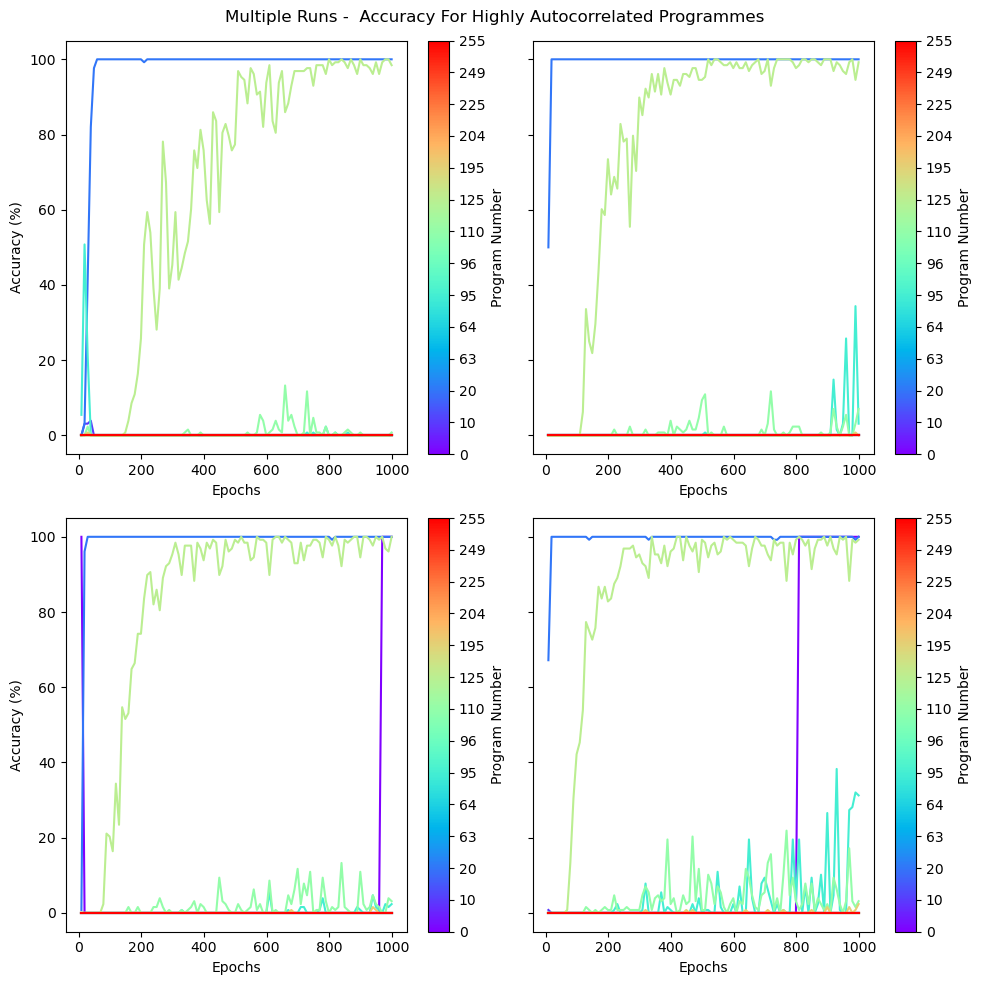

In [32]:
# Creating subplots for different runs

def accuracy_plot(ax, moving_avg, num_epochs, rel_list, repeat_idx, accuracy_array):
    
    #rows = int(num_repeats/2)
    #cols = int(num_repeats/2)
    #total_elements = rows * cols
    #repeat_idx = repeat_idx % total_elements  # Ensure index is within the range of the array's size
    
    #row = repeat_idx // cols
    #col = repeat_idx % cols
    
    #ax = axs[row, col]
    #print(row)
    #print(col)
    
    #moving_avg = 1 # The size of the averaging window being used.
    epochs = np.arange(1, num_epochs - num_epochs%moving_avg + 1,1)

    rel_list = [0, 10, 20, 63, 64, 95, 96, 110, 125, 195, 204, 225, 249, 255]
    rel_array = np.array(rel_list)
    #lines_plotted = uncorr_array[0:3]
    #lines_plotted = rel_array[2: 5]
    uncorr_array = rel_array
    lines_plotted = rel_array

    rel_epochs = [x for x, index in enumerate(epochs) if index%accuracy_frequency==0]

    # Create an axis object for the line plot
    #fig, ax = plt.subplots()
    cmap = cm.get_cmap('rainbow')  # You can choose different colormaps

    # Taking values from nearby epochs and averaging
    moving_avg = 1 # The size of the averaging window being used.
    reshaped_epochs = np.reshape(rel_epochs, (-1, moving_avg))
    filtered_epochs = reshaped_epochs[:,0]
    repeated_filtered_epochs = np.repeat(filtered_epochs, moving_avg)

    for i in tqdm(lines_plotted):
        line = accuracy_array[:,i]
        #color = cmap(lines_plotted[np.where(lines_plotted==i)[0][0]] / (len(lines_plotted) - 1))
        #color = cmap(index / (len(lines_plotted) - 1))
        color = cmap(np.where(lines_plotted == i)[0][0] / (len(lines_plotted) - 1))
        reshaped_line = np.reshape(line, (-1, moving_avg))
        programme_label = 'Programme: ' + str(uncorr_array[np.where(lines_plotted==i)][0])
        pandas_df = pd.DataFrame({programme_label: reshaped_line.flatten(), 'Epochs': repeated_filtered_epochs})
        pandas_df_melted = pd.melt(pandas_df, id_vars = 'Epochs', value_vars = [programme_label], var_name='line', value_name = 'Values')
        #fig, ax = plt.subplots()
        sns.lineplot(data=pandas_df_melted, x='Epochs', y='Values', hue='line', ax=ax, palette = [color])

    # Create a ScalarMappable object for the colorbar
    norm = plt.Normalize(0, len(lines_plotted) - 1)
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])  # Set an empty array to associate with the colorbar
    cbar = plt.colorbar(sm, ax=ax)

    cbar.set_label('Program Number')

    num_ticks = len(lines_plotted)  # Number of desired ticks
    indices = np.linspace(0, len(lines_plotted) - 1, num_ticks, dtype=int)
    tick_positions = indices
    tick_labels = lines_plotted[indices]

    cbar.set_ticks(tick_positions)
    cbar.set_ticklabels(tick_labels)

    ax.get_legend().remove()

    ax.set_ylabel('Accuracy (%)')

    #plt.show()
    
    
#rel_list = [0, 10, 20, 63, 64, 95, 96, 110, 125, 195, 204, 225, 249, 255]
rel_list = [0, 10, 20, 63, 64, 95, 96, 110, 125, 195, 204, 225]
num_repeats = 4 # Must be even, sorry
moving_avg = 1
fig, axs = plt.subplots(2, int(num_repeats/2), figsize=(5*(int(num_repeats/2)),5*(int(num_repeats/2))), sharey='row')
training_loss_list = []
accuracy_array_list = []
for repeat_idx in range(num_repeats):
    reset_weights(model)
    [training_loss, accuracy_array] = main_train(data_size, programmes_prob_distribution, batch_size, timesteps, num_epochs)
    training_loss_list.append(training_loss)
    accuracy_array_list.append(accuracy_array)
    accuracy_plot(axs[repeat_idx // (num_repeats//2), repeat_idx % (num_repeats//2)], moving_avg, num_epochs, rel_list, repeat_idx, accuracy_array)
    
plt.suptitle('Multiple Runs -  Accuracy For Highly Autocorrelated Programmes')
plt.tight_layout()
plt.show()  

In [34]:
# Pickle the results of the above calculation to avoid unneccesary corruption

import pickle

# Save training_loss_list to a file
with open('training_loss_list_hier.pkl', 'wb') as f:
    pickle.dump(training_loss_list, f)
    
# Saving accuracy array
with open('accuracy_array_list_hier.pkl', 'wb') as f:
    pickle.dump(accuracy_array_list, f)

In [35]:
# Accuracy plotting function by itself

def accuracy_plot(ax, moving_avg, num_epochs, rel_list, repeat_idx, accuracy_array):
    
    print(f'moving average = ', moving_avg)
    
    epochs = np.arange(1, num_epochs - num_epochs%moving_avg + 1,1)

    rel_array = np.array(rel_list)
    #lines_plotted = uncorr_array[0:3]
    #lines_plotted = rel_array[2: 5]
    uncorr_array = rel_array
    lines_plotted = rel_array

    rel_epochs = [x for x, index in enumerate(epochs) if index%accuracy_frequency==0]

    # Create an axis object for the line plot
    cmap = cm.get_cmap('rainbow')  # You can choose different colormaps

    # Taking values from nearby epochs and averaging
    reshaped_epochs = np.reshape(rel_epochs, (-1, moving_avg))
    filtered_epochs = reshaped_epochs[:,0]
    repeated_filtered_epochs = np.repeat(filtered_epochs, moving_avg)

    for i in tqdm(lines_plotted):
        line = accuracy_array[:,i]
        #color = cmap(lines_plotted[np.where(lines_plotted==i)[0][0]] / (len(lines_plotted) - 1))
        #color = cmap(index / (len(lines_plotted) - 1))
        color = cmap(np.where(lines_plotted == i)[0][0] / (len(lines_plotted) - 1))
        reshaped_line = np.reshape(line, (-1, moving_avg))
        programme_label = 'Programme: ' + str(uncorr_array[np.where(lines_plotted==i)][0])
        pandas_df = pd.DataFrame({programme_label: reshaped_line.flatten(), 'Epochs': repeated_filtered_epochs})
        pandas_df_melted = pd.melt(pandas_df, id_vars = 'Epochs', value_vars = [programme_label], var_name='line', value_name = 'Values')
        #fig, ax = plt.subplots()
        sns.lineplot(data=pandas_df_melted, x='Epochs', y='Values', hue='line', ax=ax, palette = [color])

    # Create a ScalarMappable object for the colorbar
    norm = plt.Normalize(0, len(lines_plotted) - 1)
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])  # Set an empty array to associate with the colorbar
    cbar = plt.colorbar(sm, ax=ax)

    cbar.set_label('Program Number')

    num_ticks = len(lines_plotted)  # Number of desired ticks
    indices = np.linspace(0, len(lines_plotted) - 1, num_ticks, dtype=int)
    tick_positions = indices
    tick_labels = lines_plotted[indices]

    cbar.set_ticks(tick_positions)
    cbar.set_ticklabels(tick_labels)

    ax.get_legend().remove()

    ax.set_ylabel('Accuracy (%)')

C:\Users\plogo\AppData\Local\Temp\ipykernel_20828\1564914665.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow')  # You can choose different colormaps


moving average =  1


100%|██████████| 12/12 [00:00<00:00, 31.79it/s]
C:\Users\plogo\AppData\Local\Temp\ipykernel_20828\1564914665.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow')  # You can choose different colormaps


moving average =  1


100%|██████████| 12/12 [00:00<00:00, 34.75it/s]
C:\Users\plogo\AppData\Local\Temp\ipykernel_20828\1564914665.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow')  # You can choose different colormaps


moving average =  1


100%|██████████| 12/12 [00:00<00:00, 31.06it/s]
C:\Users\plogo\AppData\Local\Temp\ipykernel_20828\1564914665.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow')  # You can choose different colormaps


moving average =  1


100%|██████████| 12/12 [00:00<00:00, 36.43it/s]


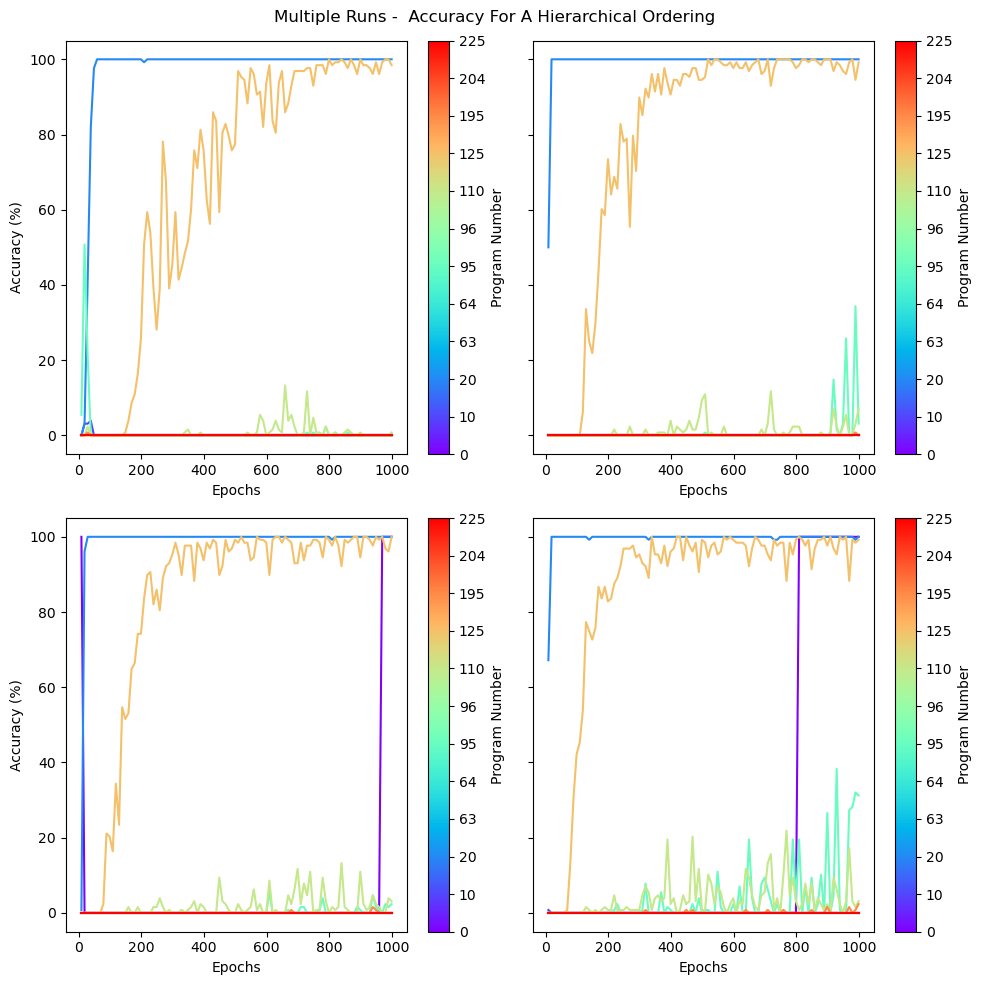

In [37]:
# For adjusting plots made as above

rel_list = [0, 10, 20, 63, 64, 95, 96, 110, 125, 195, 204, 225]
num_repeats = 4 # Must be even, sorry
moving_avg = 1
fig, axs = plt.subplots(2, int(num_repeats/2), figsize=(5*(int(num_repeats/2)),5*(int(num_repeats/2))), sharey='row')
for repeat_idx in range(num_repeats):
    #reset_weights(model)
    #[training_loss, accuracy_array] = main_train(data_size, programmes_prob_distribution, batch_size, timesteps, num_epochs)
    #training_loss_list.append(training_loss)
    #accuracy_array_list.append(accuracy_array)
    accuracy_array = accuracy_array_list[repeat_idx]
    accuracy_plot(axs[repeat_idx // (num_repeats//2), repeat_idx % (num_repeats//2)], moving_avg, num_epochs, rel_list, repeat_idx, accuracy_array)
    
plt.suptitle('Multiple Runs -  Accuracy For A Hierarchical Ordering')
plt.tight_layout()
plt.show()  